<h1 align="center">Facial Recognition</h1>

In [137]:
import numpy as np
from os import walk
from scipy.misc import imread
from scipy import linalg as la

from matplotlib import pyplot as plt, rcParams
%matplotlib inline
# rcParams["figure.figsize"] = (16,12)    # Use this line to increase your figure size (optional).

### Helper Functions

In [6]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, flatten=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, flatten=True))

In [7]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    plt.imshow(np.reshape(image,(m,n)),cmap='gray')
    plt.axis("off")
    plt.show()

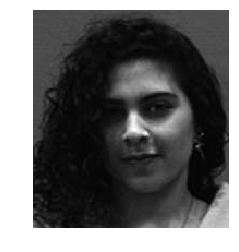

In [9]:
# Show a face from the faces94 dataset.
show(get_faces()[:,4])

## Facial Recognition Class

In [212]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
    F (matrix (mn,k)): The face vectors
    meanFace (list): The element-wise average of each face vector
    Fbar (matrix (mn,k)): The mean-shifted faces
    U: compact SVD of Fbar
        
    """
    def __init__(self, path='./faces94'):
        """Initialize all attributes.
        This is the main part of the computation.
        """
        self.F=get_faces(path)
        self.meanFace = np.array(np.mean(self.F,axis=1))
        self.Fbar=np.array([self.F[:,i]-self.meanFace for i in range(len(self.F[0]))])
        self.U=np.linalg.svd(self.Fbar.T,full_matrices=False)[0]
        

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:,:s].T@A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        return np.argmin(la.norm((self.project(self.Fbar.T,s).T-self.project((g-self.meanFace),s)).T,axis=0))

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        show(image,m,n)
        show(self.F[:,self.find_nearest(image,s)],m,n)

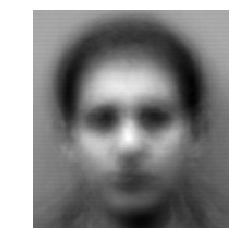

In [80]:
# Display the mean face.
fac = FacialRec()
show(fac.meanFace)

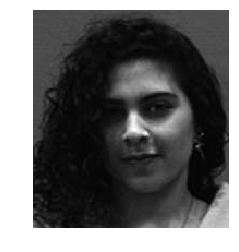

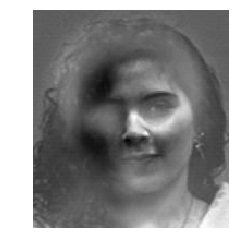

In [57]:
# Display an image along with its mean-shifted face.
show(get_faces()[:,4])
fac = FacialRec()
show(fac.Fbar[4])

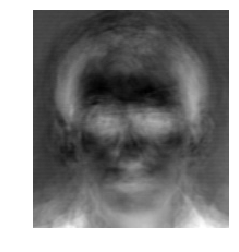

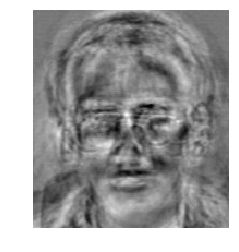

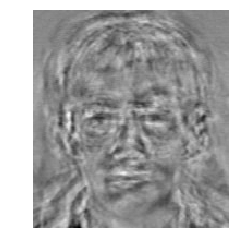

In [116]:
# Display some of the eigenfaces.
fac = FacialRec()
show(fac.U[0][:,0])
show(fac.U[0][:,50])
show(fac.U[0][:,100])

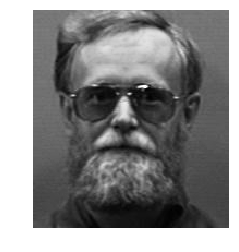

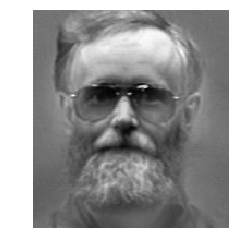

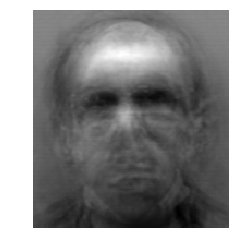

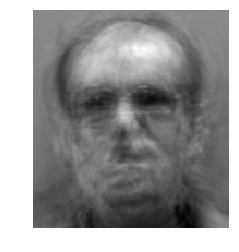

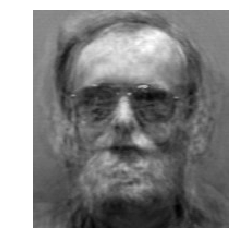

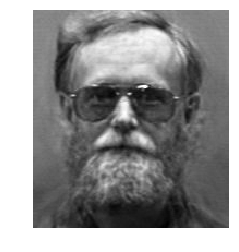

In [191]:
# Display a face image reconstructed with various numbers of eigenfaces. 
fac = FacialRec()
fbar = fac.Fbar[-3]
show(fac.F[:,-3])
show(fbar)
show(fac.U[:,:10]@fac.project(fbar,10)+fac.meanFace)
show(fac.U[:,:30]@fac.project(fbar,30)+fac.meanFace)
show(fac.U[:,:60]@fac.project(fbar,60)+fac.meanFace)
show(fac.U[:,:100]@fac.project(fbar,100)+fac.meanFace)

## Goal:

- Generate some random faces with `sample_faces()`, and use `FacialRec.match_faces()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

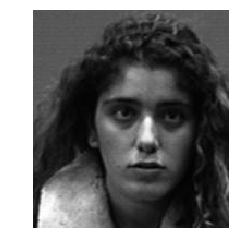

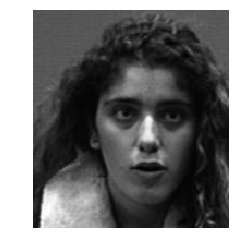

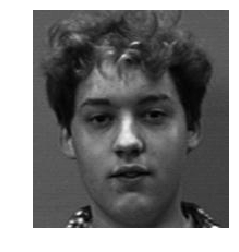

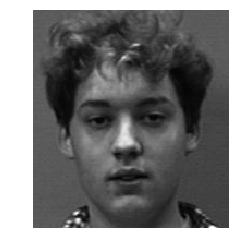

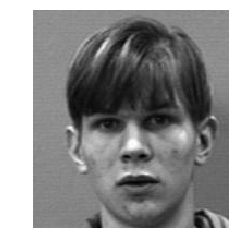

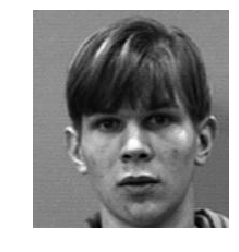

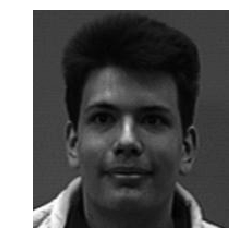

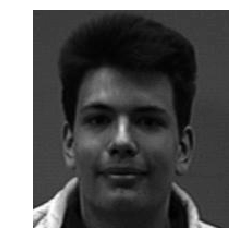

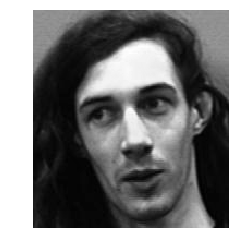

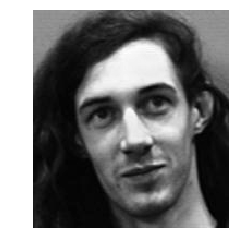

In [214]:
# Display some random images along with their closest match.
fac = FacialRec()
for test_image in sample_faces(5):
    fac.match(test_image)

As you can see, we matched every provided face with one of the faces in the dataset!